<a href="https://colab.research.google.com/github/Amandaagambire/Galamsey-Watch/blob/main/Galamsey_Watch_Amanda_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install geemap
!pip install folium
!pip install rasterio
!pip install segmentation-models-pytorch
!pip install pyngrok
!pip install flask
!pip install earthengine-api --upgrade


  Using cached flask-3.1.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached flask-3.1.0-py3-none-any.whl (102 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


# **Authentincate & initialize earth engine**

In [ ]:
from google.colab import drive
import ee
import geemap
import folium
import rasterio
from PIL import Image
import numpy as np
import os
import numpy as np
from google.colab import drive
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
import shutil
from google.colab.output import eval_js
from pyngrok import ngrok
# from flask import Flask, request, jsonify, render_template




# Mount Google Drive
drive.mount('/content/drive')

#Authenticae then initialise google Earth Engine
ee.Authenticate()
ee.Initialize(project = 'ee-amandaagambire22')
print("Earth Engine Initialized")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Earth Engine Initialized


# **DATA ACQUISITION: Fetching Sentinel -2 Images**

In [ ]:
#Define Region of Interest
ghana = ee.FeatureCollection("FAO/GAUL/2015/level0") \
          .filter(ee.Filter.eq('ADM0_NAME', 'Ghana'))
# Define time range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Sentinel-2 ImageCollection
sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate(start_date, end_date) \
    .filterBounds(ghana) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median() \
    .clip(ghana)

rgb_nir = sentinel.select(['B4', 'B3', 'B2', 'B8'])


# **Vizulaize the Extracted images**

In [ ]:

Map = geemap.Map(center = [5.2, -2.1], zoom=10)


Map.addLayer(sentinel, {'min': 0, 'max': 3000}, "Sentinel-2 RGB")
# Map.addLayer(landsat_rgb, {'min': 0, 'max': 3000}, "Landsat-8")

#Lets see it
Map

Map(center=[5.2, -2.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

 # **Export to Google Drive as GeoTIFF**

In [ ]:
# task = ee.batch.Export.image.toDrive(
#     image=rgb_nir,
#     description='ghana_sentinel_image',
#     folder='GEE_Exports',
#     fileNamePrefix='ghana_rgbnir',
#     region=ghana.geometry(),
#     scale=10,
#     maxPixels=1e13
# )
# task.start()


# **Load the GeoTIFF into Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import rasterio
import matplotlib.pyplot as plt

import os
base_path = '/content/drive/MyDrive/'

# Show all folders/files inside your Drive root
# for root, dirs, files in os.walk(base_path):
#     print(f"\nIn folder: {root}")
#     for file in files:
#         print(file)

tif_path = '/content/drive/MyDrive/galamsey_detection/ghana_rgbnir.tif'
if not os.path.exists(tif_path):
    raise FileNotFoundError(f"File not found at: {tif_path}")

with rasterio.open(tif_path) as src:
    img = src.read()  # shape: (bands, height, width)
    profile = src.profile


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Feature Extraction & Visualization**

In [ ]:
# Band order: B4 (Red), B3 (Green), B2 (Blue), B8 (NIR)
red, green, blue, nir = img[0], img[1], img[2], img[3]

print(f"Image shape: {img.shape}")  # Should be (4, H, W)

def normalize_band(band):
    band = band.astype(np.float32)
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)
    if band_max - band_min == 0:
        return np.zeros_like(band, dtype=np.uint8)
    normalized = (band - band_min) / (band_max - band_min)
    return np.clip(normalized * 255, 0, 255).astype(np.uint8)

red_n = normalize_band(red)
green_n = normalize_band(green)
blue_n = normalize_band(blue)
nir_raw = nir.astype(np.float32)
nir_n = normalize_band(nir_raw)
rgb_img = np.dstack((red_n, green_n, blue_n))#.astype(np.uint8)

print("🚨 Raw NIR stats")
print("Min:", np.nanmin(img[3]))
print("Max:", np.nanmax(img[3]))
print("Mean:", np.nanmean(img[3]))


Image shape: (4, 11776, 11776)
🚨 Raw NIR stats
Min: 1204.0
Max: 10324.0
Mean: 3258.8885163067607


# **Slice the Image into 256×256 Patches**
### **Remove the clouds & make image clear**
NOTE: mining activities in the study area usually cause a **removal of vegetation and thecreation of dug-outs**.

Normalized Difference Vegetation Index (**NDVI**) helps detect vegetation vs. non-vegetation areas:

$$NDIV = \frac{NIR - RED}{NIR +RED}$$



*   *NIR (Near-Infrared Band, B8)* = High for vegetation
*   *RED (B4)* = Low for vegetation
* Clouds & shadows usually have*NDVI near 0 or negative*


⚠️ Skipping patch at (0,0) — NDVI is all NaN
⚠️ Skipping patch at (0,256) — NDVI is all NaN
⚠️ Skipping patch at (0,512) — NDVI is all NaN
⚠️ Skipping patch at (0,768) — NDVI is all NaN
⚠️ Skipping patch at (0,1024) — NDVI is all NaN
⚠️ Skipping patch at (0,1280) — NDVI is all NaN
⚠️ Skipping patch at (0,1536) — NDVI is all NaN
⚠️ Skipping patch at (0,1792) — NDVI is all NaN
⚠️ Skipping patch at (0,2048) — NDVI is all NaN
⚠️ Skipping patch at (0,2304) — NDVI is all NaN
⚠️ Skipping patch at (0,2560) — NDVI is all NaN
⚠️ Skipping patch at (0,2816) — NDVI is all NaN
⚠️ Skipping patch at (0,3072) — NDVI is all NaN
⚠️ Skipping patch at (0,3328) — NDVI is all NaN
⚠️ Skipping patch at (0,3584) — NDVI is all NaN
⚠️ Skipping patch at (0,3840) — NDVI is all NaN
⚠️ Skipping patch at (0,4096) — NDVI is all NaN
⚠️ Skipping patch at (0,4352) — NDVI is all NaN
⚠️ Skipping patch at (0,4608) — NDVI is all NaN
⚠️ Skipping patch at (0,4864) — NDVI is all NaN
⚠️ Skipping patch at (0,5120) — NDVI is all Na

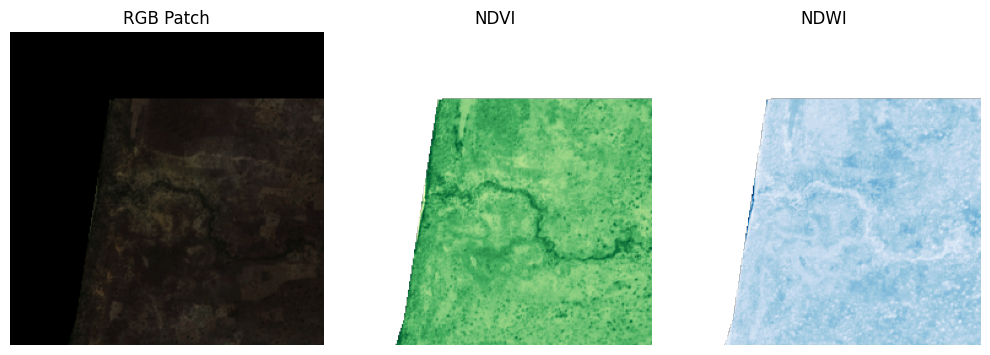

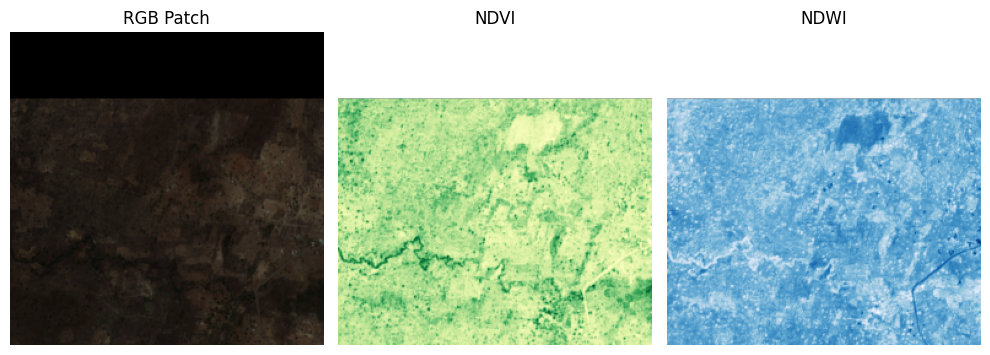

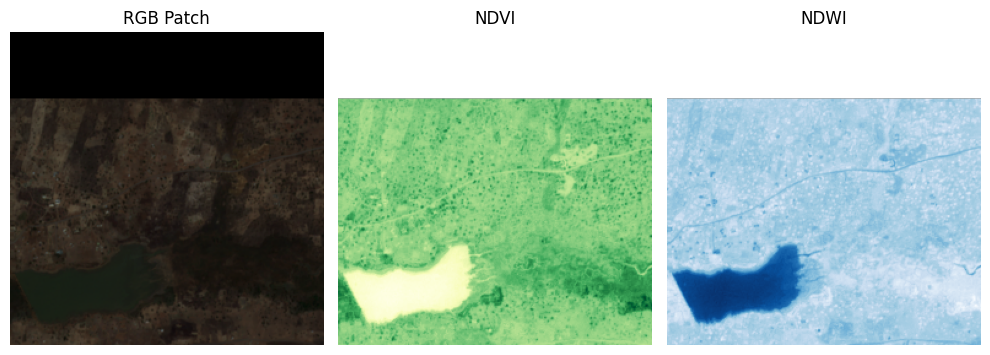

⚠️ Skipping patch at (2048,0) — NDVI is all NaN
⚠️ Skipping patch at (2048,256) — NDVI is all NaN
⚠️ Skipping patch at (2048,512) — NDVI is all NaN
⚠️ Skipping patch at (2048,768) — NDVI is all NaN
⚠️ Skipping patch at (2048,1024) — NDVI is all NaN
⚠️ Skipping patch at (2048,1280) — NDVI is all NaN
⚠️ Skipping patch at (2048,1536) — NDVI is all NaN
⚠️ Skipping patch at (2048,1792) — NDVI is all NaN
⚠️ Skipping patch at (2048,2048) — NDVI is all NaN
⚠️ Skipping patch at (2048,2304) — NDVI is all NaN
⚠️ Skipping patch at (2048,2560) — NDVI is all NaN
⚠️ Skipping patch at (2048,2816) — NDVI is all NaN
⚠️ Skipping patch at (2048,3072) — NDVI is all NaN
⚠️ Skipping patch at (2048,3328) — NDVI is all NaN
⚠️ Skipping patch at (2048,3584) — NDVI is all NaN
⚠️ Skipping patch at (2048,3840) — NDVI is all NaN
⚠️ Skipping patch at (2048,4096) — NDVI is all NaN
⚠️ Skipping patch at (2048,4352) — NDVI is all NaN
⚠️ Skipping patch at (2304,0) — NDVI is all NaN
⚠️ Skipping patch at (2304,256) — NDVI i

In [ ]:
PATCH_SIZE = 256
# H, W, _ = rgb_img.shape
rows = []
H, W = nir.shape

for i in range(0, H - PATCH_SIZE + 1, PATCH_SIZE):
    for j in range(0, W - PATCH_SIZE + 1, PATCH_SIZE):
        # Raw bands for NDVI/NDWI
        nir_patch = nir[i:i+PATCH_SIZE, j:j+PATCH_SIZE].astype(np.float32)
        red_patch = red[i:i+PATCH_SIZE, j:j+PATCH_SIZE].astype(np.float32)
        green_patch = green[i:i+PATCH_SIZE, j:j+PATCH_SIZE].astype(np.float32)

        # RGB patch for display & GLCM
        rgb_patch = rgb_img[i:i+PATCH_SIZE, j:j+PATCH_SIZE]

        # Safety check: patch sizes
        if rgb_patch.shape[0] != PATCH_SIZE or rgb_patch.shape[1] != PATCH_SIZE:
            continue

        # NDVI & NDWI (use raw bands)
        ndvi = (nir_patch - red_patch) / (nir_patch + red_patch + 1e-5)
        ndwi = (green_patch - nir_patch) / (green_patch + nir_patch + 1e-5)

        if np.isnan(ndvi).all():
            print(f"⚠️ Skipping patch at ({i},{j}) — NDVI is all NaN")
            continue

        # GLCM texture features
        gray = rgb2gray(rgb_patch)
        glcm = graycomatrix((gray * 255).astype(np.uint8),
                            distances=[5], angles=[0],
                            levels=256, symmetric=True, normed=True)

        row = {
            "ndvi_mean": np.nanmean(ndvi),
            "ndvi_std": np.nanstd(ndvi),
            "ndwi_mean": np.nanmean(ndwi),
            "ndwi_std": np.nanstd(ndwi),
            "glcm_contrast": graycoprops(glcm, 'contrast')[0, 0],
            "glcm_dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
            "glcm_homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
            "glcm_energy": graycoprops(glcm, 'energy')[0, 0],
            "glcm_correlation": graycoprops(glcm, 'correlation')[0, 0],
        }
        rows.append(row)

        # Visual check: first 3 patches
        if len(rows) <= 3:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(rgb_patch)
            plt.title("RGB Patch")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(ndvi, cmap='YlGn')
            plt.title("NDVI")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(ndwi, cmap='Blues')
            plt.title("NDWI")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

feature_df = pd.DataFrame(rows)
print("✅ Feature extraction complete.")
print(feature_df.head())


In [ ]:
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(rgb_img)
# plt.title("Original RGB")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(rgb_img, alpha=0.7)
# plt.imshow(pred_map, cmap='coolwarm', alpha=0.4)
# plt.title("Predicted Mining Zones Overlay")
# plt.axis('off')

# plt.tight_layout()
# plt.show()
# print("✅ RGB stats:")
# print("Shape:", rgb_img.shape)
# print("Min pixel value:", rgb_img.min())
# print("Max pixel value:", rgb_img.max())
# print("Unique values:", np.unique(rgb_img))

# **Visualize RGB and NDWI Map**
This gives you three polished visuals:

Natural color view

Vegetation (NDVI) heatmap

Water content (NDWI) heatmap

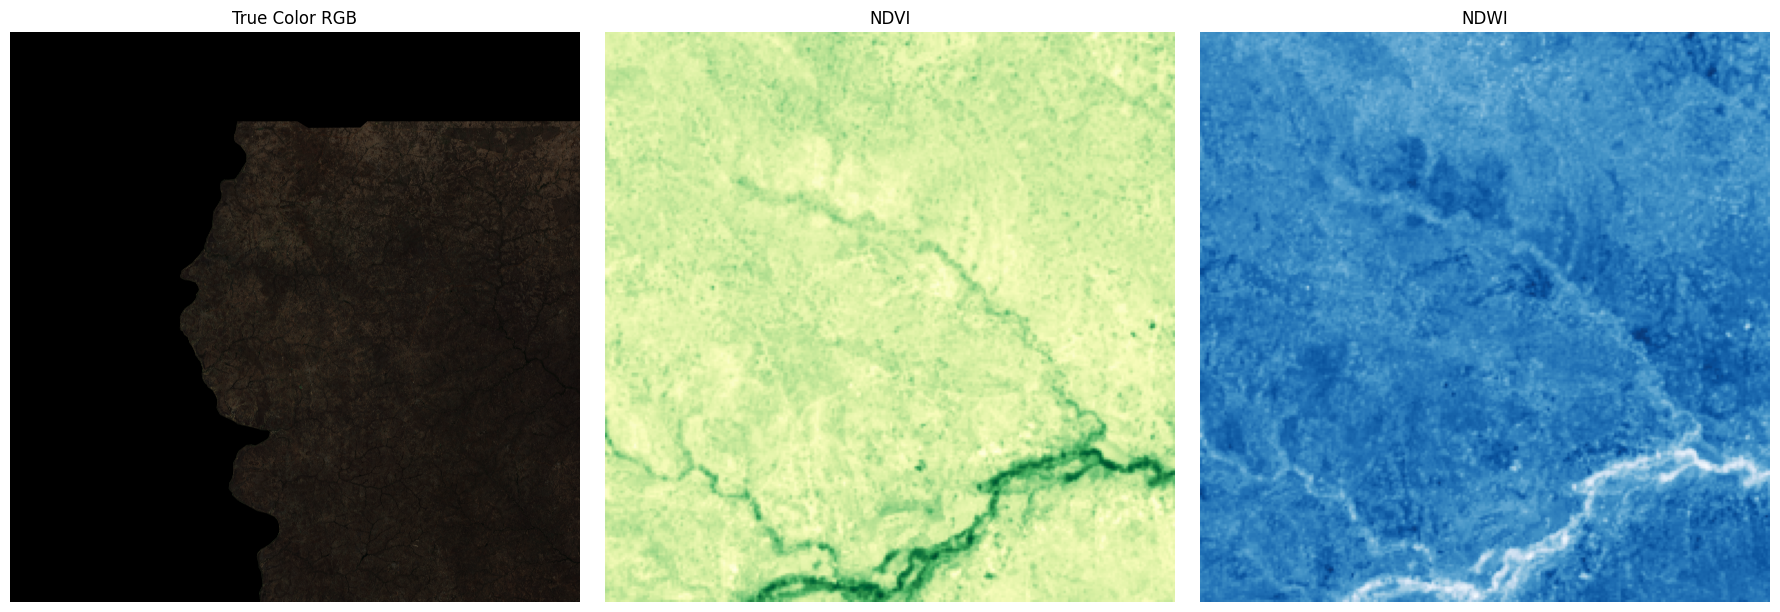

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# RGB composite
rgb_img = np.dstack((red_n, green_n, blue_n))
axs[0].imshow(rgb_img)
axs[0].set_title("True Color RGB")

# NDVI
axs[1].imshow(ndvi, cmap='YlGn')
axs[1].set_title("NDVI")

# NDWI
axs[2].imshow(ndwi, cmap='Blues')
axs[2].set_title("NDWI")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


# **Preview a few sample patches**

In [ ]:
# for idx in range(3):
#     fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#     axs[0].imshow(patches[idx]['rgb'])
#     axs[0].set_title("RGB Patch")

#     axs[1].imshow(patches[idx]['ndvi'], cmap='YlGn')
#     axs[1].set_title("NDVI Patch")

#     axs[2].imshow(patches[idx]['ndwi'], cmap='Blues')
#     axs[2].set_title("NDWI Patch")

#     for ax in axs:
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()


# **Train and Evaluate a Classifier (Random Forest)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Label: 1 = likely illegal mining, 0 = vegetation
feature_df['label'] = (feature_df['ndvi_mean'] < 0.2).astype(int)

# Split features and labels
X = feature_df.drop('label', axis=1)
y = feature_df['label']

#Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#Evaluate Performance
y_pred = rf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[ 90   0]
 [  0 140]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00       140

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230



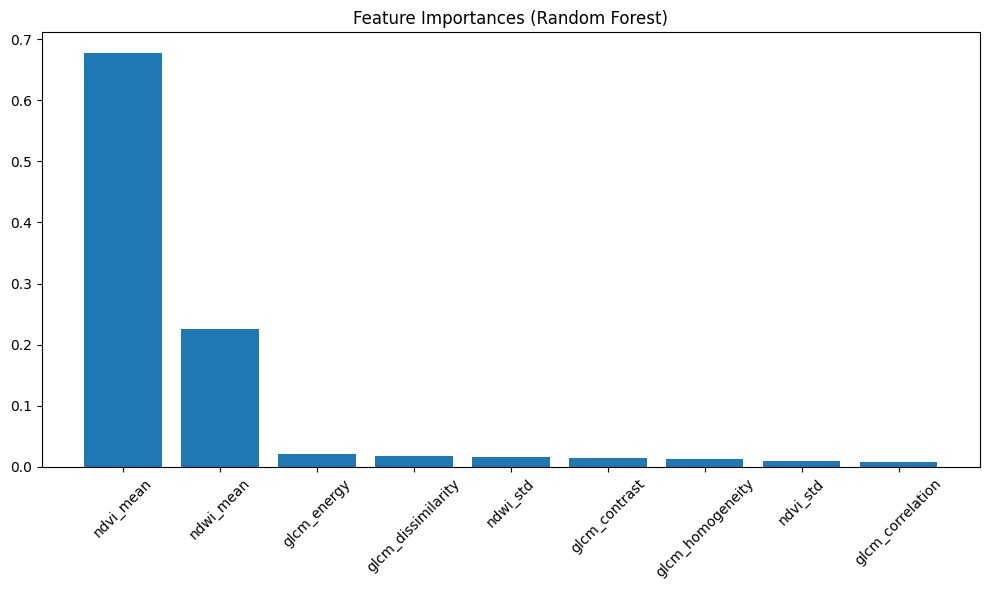

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feat_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


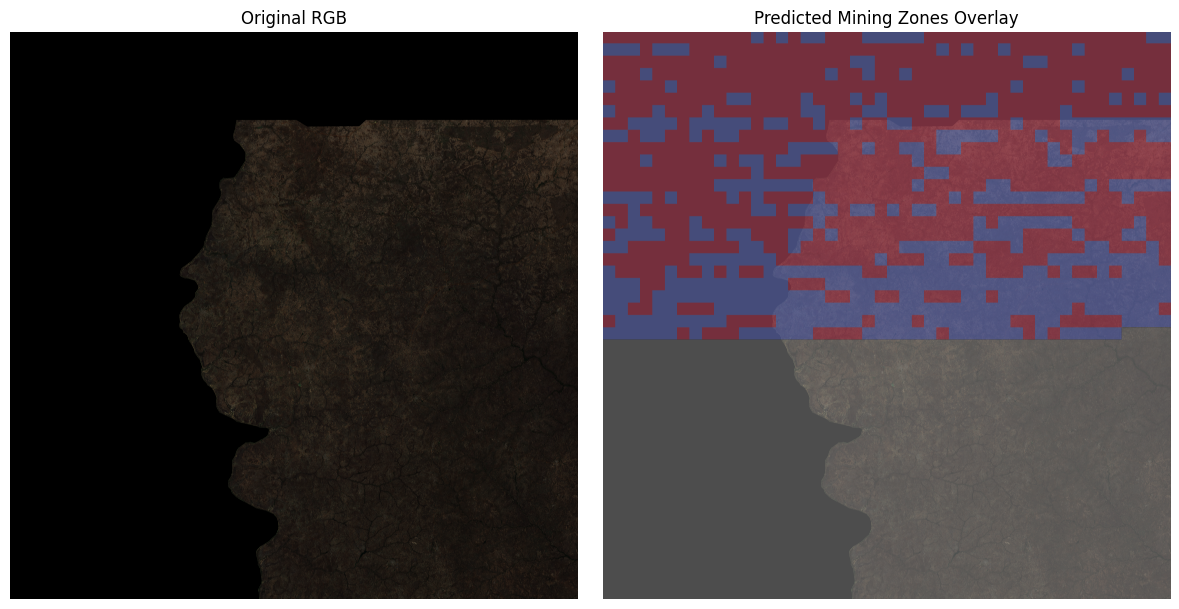

In [ ]:
# === Step 7: Map Predictions Back to Image ===

# Create blank prediction map (same H and W as image, filled with NaNs)
pred_map = np.full((H, W), np.nan)

# Reset counters
patch_idx = 0

for i in range(0, H, PATCH_SIZE):
    for j in range(0, W, PATCH_SIZE):
        if i + PATCH_SIZE <= H and j + PATCH_SIZE <= W:
            # Only use patches used in training/testing (feature_df row count)
            if patch_idx < len(feature_df):
                label = feature_df.iloc[patch_idx]['label']
                pred_map[i:i+PATCH_SIZE, j:j+PATCH_SIZE] = label
                patch_idx += 1
plt.figure(figsize=(12, 6))

# RGB image (normalized)
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title("Original RGB")
plt.axis('off')

# Prediction heatmap
plt.subplot(1, 2, 2)
plt.imshow(rgb_img, alpha=0.7)
plt.imshow(pred_map, cmap='coolwarm', alpha=0.4)  # red/blue mask
plt.title("Predicted Mining Zones Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()


# **Save Visualization**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Red = illegal mining (1), Blue = no mining (0)
cmap = ListedColormap(["blue", "red"])

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Show RGB
axs[0].imshow(rgb_img)
axs[0].set_title("RGB Image")
axs[0].axis("off")

# Show predictions
axs[1].imshow(pred_map, cmap=cmap, alpha=0.6)
axs[1].set_title("Predicted Mining Zones")
axs[1].axis("off")

plt.tight_layout()

# Save as PNG to Drive
png_path = "/content/drive/MyDrive/galamsey_detection/mining_prediction_overlay.png"
plt.savefig(png_path, dpi=300)
plt.close()

print(f"✅ PNG saved at: {png_path}")


✅ PNG saved at: /content/drive/MyDrive/galamsey_detection/mining_prediction_overlay.png


# **Export Prediction Map as GeoTIFF**


In [ ]:
from rasterio.transform import from_origin

# Prediction map is in patch format, map it back to full image size
# We assume prediction_map already matches the spatial layout

tif_output_path = "/content/drive/MyDrive/galamsey_detection/mining_prediction.tif"

# Reuse profile from original image (change dtype and count)
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw'
)

with rasterio.open(tif_output_path, 'w', **profile) as dst:
    dst.write(pred_map.astype(rasterio.uint8), 1)

print(f"✅ GeoTIFF saved at: {tif_output_path}")


✅ GeoTIFF saved at: /content/drive/MyDrive/galamsey_detection/mining_prediction.tif


# **Extract Features from Each Patch**

In [ ]:
# from skimage.feature import graycomatrix, graycoprops

# def extract_glcm_features(patch, distances=[5], angles=[0], levels=256):
#     # Convert NDVI to 8-bit grayscale
#     ndvi_8bit = ((patch['ndvi'] - np.min(patch['ndvi'])) / (np.max(patch['ndvi']) - np.min(patch['ndvi'])) * 255).astype(np.uint8)

#     glcm = graycomatrix(ndvi_8bit, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
#     contrast = graycoprops(glcm, 'contrast')[0, 0]
#     dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
#     homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
#     energy = graycoprops(glcm, 'energy')[0, 0]
#     correlation = graycoprops(glcm, 'correlation')[0, 0]

#     return [contrast, dissimilarity, homogeneity, energy, correlation]

# # Loop through patches and extract features
# features = []
# for patch in patches:
#     ndvi_mean = np.mean(patch['ndvi'])
#     ndvi_std = np.std(patch['ndvi'])
#     ndwi_mean = np.mean(patch['ndwi'])
#     ndwi_std = np.std(patch['ndwi'])
#     glcm_feats = extract_glcm_features(patch)

#     features.append([ndvi_mean, ndvi_std, ndwi_mean, ndwi_std] + glcm_feats)

# import pandas as pd
# feature_df = pd.DataFrame(features, columns=[
#     'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std',
#     'glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation'
# ])
# feature_df.head()


# **Create Labels**

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# labels = (feature_df['ndvi_mean'] < 0.2).astype(int)  # 1 = likely illegal mining
# feature_df['label'] = labels

# X = feature_df.drop('label', axis=1)
# y = feature_df['label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))


# **Importance Plot**

In [ ]:
# import matplotlib.pyplot as plt

# importances = rf.feature_importances_
# indices = np.argsort(importances)[::-1]
# feat_names = X.columns

# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances")
# plt.bar(range(X.shape[1]), importances[indices])
# plt.xticks(range(X.shape[1]), [feat_names[i] for i in indices], rotation=45)
# plt.tight_layout()
# plt.show()
